# QML 

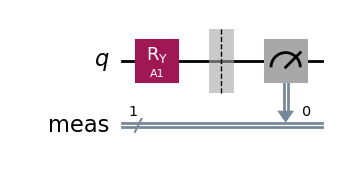

In [13]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# 1. Define a Variable (Parameter)
theta = Parameter('A1')

# 2. Create a Circuit using this variable
qc = QuantumCircuit(1)
qc.ry(theta, 0)  # Rotate by 'theta' (we don't know what theta is yet!)
qc.measure_all()

qc.draw('mpl')

In [14]:
from qiskit_aer import AerSimulator

# 1. Pick a test value for theta (e.g., PI)
test_value = 3.14159 

# 2. Bind the parameter to the circuit
# This creates a NEW circuit where theta is replaced by 3.14159
bound_qc = qc.assign_parameters({theta: test_value})

# 3. Run it
sim = AerSimulator()
result = sim.run(bound_qc, shots=1000).result().get_counts()

print(f"Input Theta: {test_value}")
print("Output:", result)

Input Theta: 3.14159
Output: {'1': 1000}


In [15]:
from qiskit_aer import AerSimulator

# 1. Pick a test value for theta (e.g., PI)
test_value = 3.14159 / 2  # Rotate by 90 degrees (PI/2)

# 2. Bind the parameter to the circuit
# This creates a NEW circuit where theta is replaced by 3.14159
bound_qc = qc.assign_parameters({theta: test_value})

# 3. Run it
sim = AerSimulator()
result = sim.run(bound_qc, shots=1000).result().get_counts()

print(f"Input Theta: {test_value}")
print("Output:", result)

Input Theta: 1.570795
Output: {'0': 503, '1': 497}


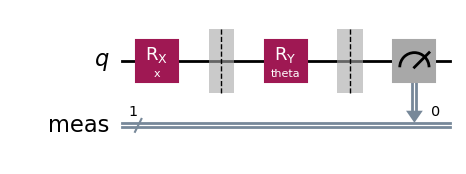

In [16]:
# 1. Define Parameters
x = Parameter('x')      # Data
theta = Parameter('theta')  # Trainable Weight

# 2. Build the "Quantum Neuron"
qc_qml = QuantumCircuit(1)

# Layer 1: Encode Data (Feature Map)
qc_qml.rx(x, 0) 
qc_qml.barrier()

# Layer 2: Trainable Weight (Ansatz)
qc_qml.ry(theta, 0)
qc_qml.measure_all()

qc_qml.draw('mpl')

In [17]:
import numpy as np

# Bind BOTH parameters
bound_circuit = qc_qml.assign_parameters({
    x: np.pi / 2,  # Input Data
    theta: 0       # Initial Weight
})

# Run
counts = sim.run(bound_circuit, shots=1000).result().get_counts()
print(f"Input x=PI/2, Weight theta=0 -> Result: {counts}")

Input x=PI/2, Weight theta=0 -> Result: {'0': 493, '1': 507}


# Binary Classification.

#### Group 0 (Blue): Numbers close to 0.

#### Group 1 (Red): Numbers close to π (3.14).

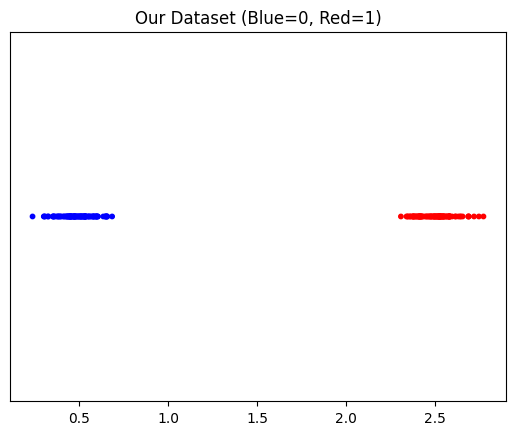

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Random Data
np.random.seed(42) # For consistent results

# Group A (Label 0): Random numbers centered around 0.5
train_data_0 = np.random.normal(0.5, 0.1, 100)
train_labels_0 = np.zeros(100)

# Group B (Label 1): Random numbers centered around 2.5
train_data_1 = np.random.normal(2.5, 0.1, 100)
train_labels_1 = np.ones(100)

# Combine them
train_data = np.concatenate([train_data_0, train_data_1]) #X_train
train_labels = np.concatenate([train_labels_0, train_labels_1]) #y_train

# Visualize
plt.scatter(train_data, np.zeros_like(train_data), c=train_labels, cmap='bwr', s=10)
plt.title("Our Dataset (Blue=0, Red=1)")
plt.yticks([]) # Hide y-axis since it's 1D data
plt.show()

### PQC For our "Binary" classification

Our Quantum Classifier:


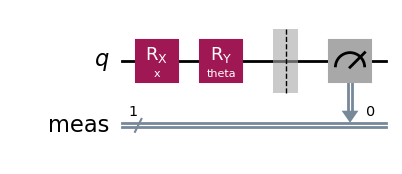

In [71]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# Define Parameters
x = Parameter('x')       # Input Data
theta = Parameter('theta')   # Trainable Weight

# Build Circuit
qc = QuantumCircuit(1)

# 1. Encode Data (Feature Map)
qc.rx(x, 0)

# 2. Trainable Layer (Ansatz)
qc.ry(theta, 0)

# 3. Measure
qc.measure_all()

print("Our Quantum Classifier:")
qc.draw('mpl')

### Important: Loss function

In [72]:
from qiskit_aer import AerSimulator

sim = AerSimulator()

def get_prediction(data_point, weight_value):
    """Run circuit for one data point and current weight."""
    # Bind parameters
    bound_qc = qc.assign_parameters({x: data_point, theta: weight_value})
    
    # Run simulation
    result = sim.run(bound_qc, shots=1000).result().get_counts()
    
    # Calculate probability of measuring '1'
    # If '1' is not in counts, it means prob is 0
    counts_1 = result.get('1', 0)
    prob_1 = counts_1 / 1000
    return prob_1

def calculate_cost(weight_value, data, labels):
    """Calculate total error (Mean Squared Error) over all data."""
    total_loss = 0
    for i in range(len(data)):
        pred = get_prediction(data[i], weight_value)
        target = labels[i]
        total_loss += (pred - target) ** 2
    return total_loss / len(data)

### The Training Loop (Optimization) (only +ve small angle)

Initial Weight: 5.513
Epoch 0: Loss = 0.0402, Weight = 5.523
Epoch 5: Loss = 0.0364, Weight = 5.574
Epoch 10: Loss = 0.0297, Weight = 5.620
Epoch 15: Loss = 0.0274, Weight = 5.650
Epoch 20: Loss = 0.0240, Weight = 5.700
Final Trained Weight: 5.728


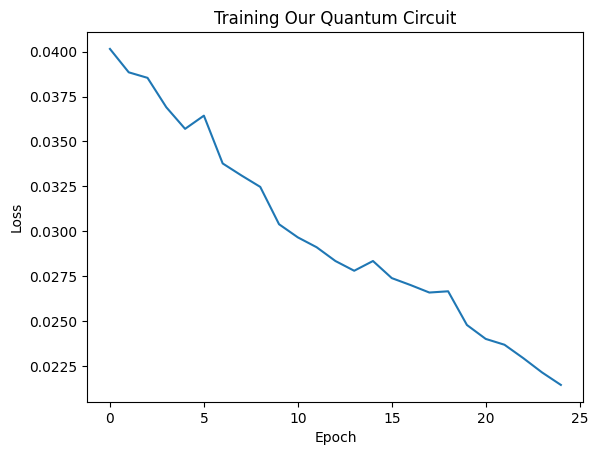

In [73]:
# Hyperparameters
current_weight = np.random.rand() * 2 * np.pi  # Random start
learning_rate = 0.1
epochs = 25

loss_history = []

print(f"Initial Weight: {current_weight:.3f}")

# Training Loop
for epoch in range(epochs):
    # 1. Calculate current loss
    loss = calculate_cost(current_weight, train_data, train_labels)
    loss_history.append(loss)
    
    # 2. Estimate Gradient (Finite Difference)
    # See how loss changes if we increase weight slightly
    loss_plus = calculate_cost(current_weight + 0.01, train_data, train_labels)
    gradient = (loss_plus - loss) / 0.01
    
    # 3. Update Weight (Gradient Descent)
    current_weight -= learning_rate * gradient
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Weight = {current_weight:.3f}")

print(f"Final Trained Weight: {current_weight:.3f}")

# Plot Loss Curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Our Quantum Circuit")
plt.show()

In [74]:
test_point_0 = 0.5  # Should be Class 0
test_point_1 = 2.5  # Should be Class 1

prob_0 = get_prediction(test_point_0, current_weight)
prob_1 = get_prediction(test_point_1, current_weight)

print(f"Prediction for input 0.5 (Target 0): {prob_0:.3f} (Probability of being Class 1)")
print(f"Prediction for input 2.5 (Target 1): {prob_1:.3f} (Probability of being Class 1)")

Prediction for input 0.5 (Target 0): 0.129 (Probability of being Class 1)
Prediction for input 2.5 (Target 1): 0.856 (Probability of being Class 1)


Initial Weight: 4.654
Epoch 0: Loss = 0.2735, Weight = 4.696, Grad = -0.419
Epoch 5: Loss = 0.1905, Weight = 4.905, Grad = -0.415
Epoch 10: Loss = 0.1258, Weight = 5.107, Grad = -0.394
Epoch 15: Loss = 0.0797, Weight = 5.293, Grad = -0.358
Epoch 20: Loss = 0.0509, Weight = 5.460, Grad = -0.317
Epoch 25: Loss = 0.0337, Weight = 5.605, Grad = -0.272
Epoch 30: Loss = 0.0229, Weight = 5.728, Grad = -0.229
Epoch 35: Loss = 0.0171, Weight = 5.831, Grad = -0.190
Epoch 40: Loss = 0.0133, Weight = 5.915, Grad = -0.158
Epoch 45: Loss = 0.0113, Weight = 5.985, Grad = -0.128
Final Trained Weight: 6.032


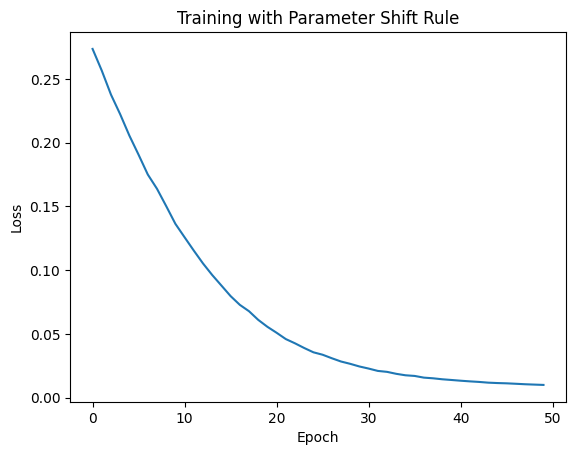

In [75]:
# Hyperparameters
current_weight = np.random.rand() * 2 * np.pi  # Random start
learning_rate = 0.1  # You can often increase this for Parameter Shift (e.g., to 0.5)
epochs = 50
shift = np.pi / 2   # The "magic" shift amount for quantum gates

loss_history = []

print(f"Initial Weight: {current_weight:.3f}")

# Training Loop
for epoch in range(epochs):
    # 1. Calculate current loss (just for tracking progress)
    loss = calculate_cost(current_weight, train_data, train_labels)
    loss_history.append(loss)
    
    # 2. Estimate Gradient (Parameter Shift Rule)
    # Instead of nudging by 0.01, we shift by ±PI/2
    loss_plus = calculate_cost(current_weight + shift, train_data, train_labels)
    loss_minus = calculate_cost(current_weight - shift, train_data, train_labels)
    
    # Gradient formula: (f(x+shift) - f(x-shift)) / 2
    gradient = (loss_plus - loss_minus) / 2
    
    # 3. Update Weight (Gradient Descent)
    current_weight -= learning_rate * gradient
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Weight = {current_weight:.3f}, Grad = {gradient:.3f}")

print(f"Final Trained Weight: {current_weight:.3f}")

# Plot Loss Curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training with Parameter Shift Rule")
plt.show()

In [34]:
test_point_0 = 0.5  # Should be Class 0
test_point_1 = 2.5  # Should be Class 1

prob_0 = get_prediction(test_point_0, current_weight)
prob_1 = get_prediction(test_point_1, current_weight)

print(f"Prediction for input 0.5 (Target 0): {prob_0:.3f} (Probability of being Class 1)")
print(f"Prediction for input 2.5 (Target 1): {prob_1:.3f} (Probability of being Class 1)")

Prediction for input 0.5 (Target 0): 0.065 (Probability of being Class 1)
Prediction for input 2.5 (Target 1): 0.878 (Probability of being Class 1)


Initial Weight: 5.090
Epoch 0: Loss = 0.1194, Weight = 5.129, Grad = -0.390
Epoch 5: Loss = 0.0761, Weight = 5.314, Grad = -0.354
Epoch 10: Loss = 0.0484, Weight = 5.478, Grad = -0.311
Epoch 15: Loss = 0.0311, Weight = 5.620, Grad = -0.267
Epoch 20: Loss = 0.0222, Weight = 5.741, Grad = -0.226
Epoch 25: Loss = 0.0168, Weight = 5.841, Grad = -0.187
Epoch 30: Loss = 0.0131, Weight = 5.924, Grad = -0.154
Epoch 35: Loss = 0.0105, Weight = 5.992, Grad = -0.125
Epoch 40: Loss = 0.0098, Weight = 6.048, Grad = -0.104
Epoch 45: Loss = 0.0090, Weight = 6.093, Grad = -0.082
Epoch 50: Loss = 0.0085, Weight = 6.130, Grad = -0.067
Epoch 55: Loss = 0.0081, Weight = 6.159, Grad = -0.054
Epoch 60: Loss = 0.0080, Weight = 6.183, Grad = -0.044
Epoch 65: Loss = 0.0080, Weight = 6.202, Grad = -0.035
Epoch 70: Loss = 0.0076, Weight = 6.218, Grad = -0.029
Epoch 75: Loss = 0.0078, Weight = 6.230, Grad = -0.023
Epoch 80: Loss = 0.0075, Weight = 6.240, Grad = -0.018
Epoch 85: Loss = 0.0076, Weight = 6.249, Grad

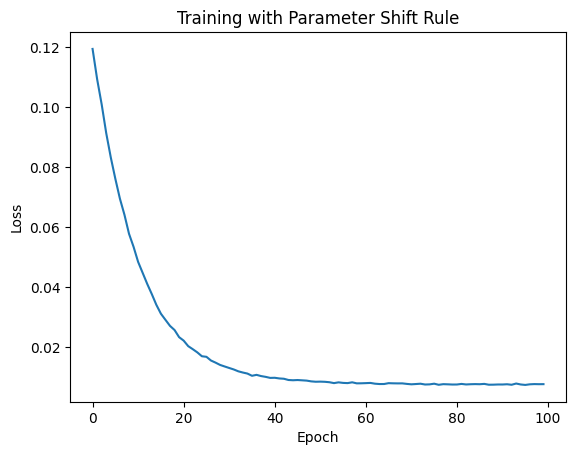

In [35]:
# Hyperparameters
current_weight = np.random.rand() * 2 * np.pi  # Random start
learning_rate = 0.1  # You can often increase this for Parameter Shift (e.g., to 0.5)
epochs = 100
shift = np.pi / 2   # The "magic" shift amount for quantum gates

loss_history = []

print(f"Initial Weight: {current_weight:.3f}")

# Training Loop
for epoch in range(epochs):
    # 1. Calculate current loss (just for tracking progress)
    loss = calculate_cost(current_weight, train_data, train_labels)
    loss_history.append(loss)
    
    # 2. Estimate Gradient (Parameter Shift Rule)
    # Instead of nudging by 0.01, we shift by ±PI/2
    loss_plus = calculate_cost(current_weight + shift, train_data, train_labels)
    loss_minus = calculate_cost(current_weight - shift, train_data, train_labels)
    
    # Gradient formula: (f(x+shift) - f(x-shift)) / 2
    gradient = (loss_plus - loss_minus) / 2
    
    # 3. Update Weight (Gradient Descent)
    current_weight -= learning_rate * gradient
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Weight = {current_weight:.3f}, Grad = {gradient:.3f}")

print(f"Final Trained Weight: {current_weight:.3f}")

# Plot Loss Curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training with Parameter Shift Rule")
plt.show()

In [36]:
test_point_0 = 0.5  # Should be Class 0
test_point_1 = 2.5  # Should be Class 1

prob_0 = get_prediction(test_point_0, current_weight)
prob_1 = get_prediction(test_point_1, current_weight)

print(f"Prediction for input 0.5 (Target 0): {prob_0:.3f} (Probability of being Class 1)")
print(f"Prediction for input 2.5 (Target 1): {prob_1:.3f} (Probability of being Class 1)")

Prediction for input 0.5 (Target 0): 0.062 (Probability of being Class 1)
Prediction for input 2.5 (Target 1): 0.914 (Probability of being Class 1)



Training Started with 12 parameters...
----------------------------------------
Epoch 0: Loss = 0.0538
Epoch 2: Loss = 0.0161
Epoch 4: Loss = 0.0064
Epoch 6: Loss = 0.0021
Epoch 8: Loss = 0.0009
Epoch 10: Loss = 0.0005
Epoch 12: Loss = 0.0003
Epoch 14: Loss = 0.0003
Epoch 16: Loss = 0.0001
Epoch 18: Loss = 0.0001
----------------------------------------
Final Results (Input -> Predicted vs Actual):
[0 0] -> 0.01 (Target: 0)
[0 1] -> 0.98 (Target: 1)
[1 0] -> 1.00 (Target: 1)
[1 1] -> 0.00 (Target: 0)


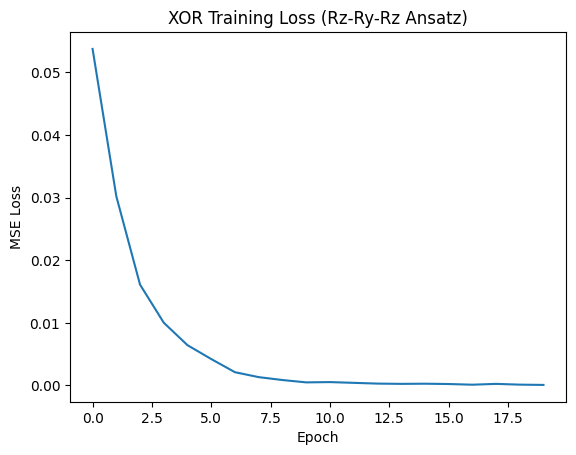

In [78]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
sim = AerSimulator()

def get_probability(x_data, w_data):
    """Run circuit and return P(11) + P(01) or P(10)...
    Let's interpret the 'parity' or just measure the last qubit."""
    
    # Bind parameters
    bind_dict = {param_input[i]: x_data[i] for i in range(NUM_QUBITS)}
    bind_dict.update({param_weight[i]: w_data[i] for i in range(len(param_weight))})
    
    bound_qc = qc.assign_parameters(bind_dict)
    counts = sim.run(bound_qc, shots=1000).result().get_counts()
    
    # We will use the Parity of the output as prediction
    # If "1" appears an odd number of times -> Predict 1
    # XOR logic: 00->0, 01->1, 10->1, 11->0
    prob_1 = 0
    for bitstring, count in counts.items():
        # Check parity: (number of 1s) % 2
        if bitstring.count('1') % 2 == 1:
            prob_1 += count
            
    return prob_1 / 1000

def compute_loss(w_data):
    """Mean Squared Error"""
    loss = 0
    for i in range(len(X_train)):
        pred = get_probability(X_train[i], w_data)
        target = Y_train[i]
        loss += (pred - target) ** 2
    return loss / len(X_train)

# ==========================================
# 4. TRAINING LOOP (Parameter Shift Rule)
# ==========================================
def get_gradients(w_data):
    """Calculate gradient for ALL weights using Parameter Shift"""
    grads = np.zeros_like(w_data)
    shift = np.pi / 2
    
    for i in range(len(w_data)):
        # Shift +
        w_plus = w_data.copy()
        w_plus[i] += shift
        loss_plus = compute_loss(w_plus)
        
        # Shift -
        w_minus = w_data.copy()
        w_minus[i] -= shift
        loss_minus = compute_loss(w_minus)
        
        # Eq. 1 in Paper
        grads[i] = (loss_plus - loss_minus) / 2
        
    return grads

# Initialize Weights
np.random.seed(42)
weights = np.random.rand(len(param_weight)) * 2 * np.pi
learning_rate = 0.2
loss_history = []

print(f"\nTraining Started with {len(weights)} parameters...")
print("-" * 40)

epochs = 20
for epoch in range(epochs):
    grads = get_gradients(weights)
    weights -= learning_rate * grads
    
    curr_loss = compute_loss(weights)
    loss_history.append(curr_loss)
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss = {curr_loss:.4f}")

# ==========================================
# 5. VERIFICATION
# ==========================================
print("-" * 40)
print("Final Results (Input -> Predicted vs Actual):")
for i in range(len(X_train)):
    pred = get_probability(X_train[i], weights)
    print(f"{X_train[i]} -> {pred:.2f} (Target: {Y_train[i]})")

plt.plot(loss_history)
plt.title("XOR Training Loss (Rz-Ry-Rz Ansatz)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

## Regression Task As ours (training for sin x)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator

# ==========================================
# 1. PREPARE DATA (Regression Task)
# ==========================================
# We want to learn y = sin(x)
# Generate 20 points between -Pi and +Pi
X_train = np.linspace(-np.pi, np.pi, 200)
Y_train = np.sin(X_train)




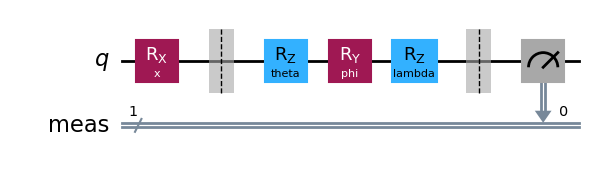

In [52]:
# ==========================================
# 2. DEFINE CIRCUIT (The "Quantum Neural Network")
# ==========================================
x = Parameter('x')          # Input Data
theta = Parameter('theta')      # Trainable Weight 1 (Rz)
phi = Parameter('phi')        # Trainable Weight 2 (Ry)
lam = Parameter('lambda')        # Trainable Weight 3 (Rz)

qc = QuantumCircuit(1)

# A. Encoding Layer (Input Data)
qc.rx(x, 0) 
qc.barrier()

# B. Trainable Ansatz (Paper Theorem 3.2: Rz-Ry-Rz)
# This combination can reach ANY state on the Bloch Sphere
qc.rz(theta, 0)
qc.ry(phi, 0)
qc.rz(lam, 0)
# C. Measurement
qc.measure_all()
qc.draw('mpl')


In [53]:

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
sim = AerSimulator()

def get_prediction(x_val, weights):
    """
    Run circuit and return Expectation Value (-1 to 1).
    Expectation = P(0) - P(1)
    """
    # Bind parameters: x and the 3 weights
    bind_dict = {
        x: x_val,
        theta: weights[0],
        phi: weights[1],
        lam: weights[2]
    }
    bound_qc = qc.assign_parameters(bind_dict)
    
    # Run simulation
    counts = sim.run(bound_qc, shots=1000).result().get_counts()
    
    # Calculate Probabilities
    prob_0 = counts.get('0', 0) / 1000
    prob_1 = counts.get('1', 0) / 1000
    
    # Expectation Value formula for Z measurement
    return prob_0 - prob_1

def compute_loss(weights):
    """Mean Squared Error (MSE) over all training data"""
    total_loss = 0
    for i in range(len(X_train)):
        pred = get_prediction(X_train[i], weights)
        target = Y_train[i]
        total_loss += (pred - target) ** 2
    return total_loss / len(X_train)




In [54]:
# ==========================================
# 4. GRADIENT DESCENT (Parameter Shift Rule)
# ==========================================
def get_gradients(current_weights):
    """
    Calculate gradient for each weight using Eq. 1 from Paper.
    """
    grads = np.zeros_like(current_weights)
    shift = np.pi / 2
    
    # Loop over each of the 3 parameters (theta, phi, lam)
    for i in range(len(current_weights)):
        # Shift Forward (+ pi/2)
        w_plus = current_weights.copy()
        w_plus[i] += shift
        loss_plus = compute_loss(w_plus)
        
        # Shift Backward (- pi/2)
        w_minus = current_weights.copy()
        w_minus[i] -= shift
        loss_minus = compute_loss(w_minus)
        
        # Gradient = (L+ - L-) / 2
        grads[i] = (loss_plus - loss_minus) / 2
        
    return grads


Initial Weights: [3.23103027 3.72225051 0.29185655]
Starting Training...
Epoch 0: Loss = 0.7736
Epoch 5: Loss = 0.0180
Training Complete!


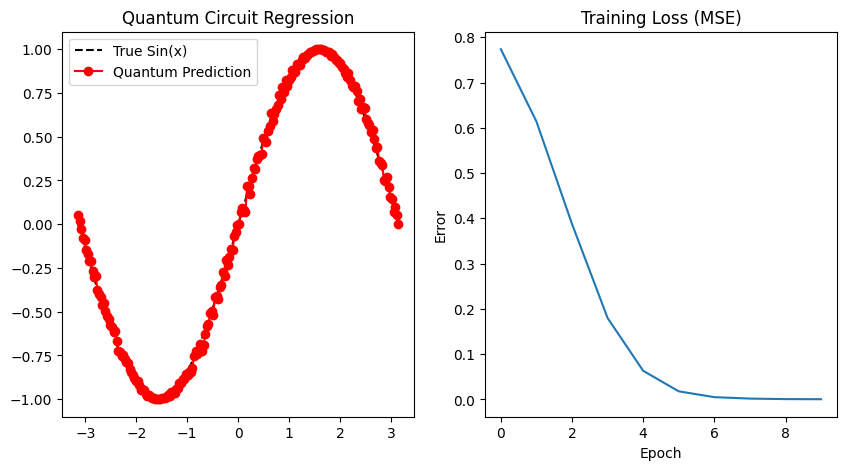

In [50]:

# ==========================================
# 5. TRAINING LOOP
# ==========================================
# Random initial weights
weights = np.random.rand(3) * 2 * np.pi
learning_rate = 0.5
loss_history = []

print(f"Initial Weights: {weights}")
print("Starting Training...")

epochs = 10
for epoch in range(epochs):
    # 1. Get Gradients
    grads = get_gradients(weights)
    
    # 2. Update Weights
    weights -= learning_rate * grads
    
    # 3. Track Loss
    curr_loss = compute_loss(weights)
    loss_history.append(curr_loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {curr_loss:.4f}")

print("Training Complete!")

# ==========================================
# 6. VISUALIZE RESULTS
# ==========================================
# Get predictions from the trained model
predictions = [get_prediction(x_i, weights) for x_i in X_train]

plt.figure(figsize=(10, 5))

# Plot 1: The Function Fit
plt.subplot(1, 2, 1)
plt.plot(X_train, Y_train, 'k--', label='True Sin(x)')
plt.plot(X_train, predictions, 'ro-', label='Quantum Prediction')
plt.title("Quantum Circuit Regression")
plt.legend()

# Plot 2: The Training Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

### training with entanglement

Coupled Signal Circuit:


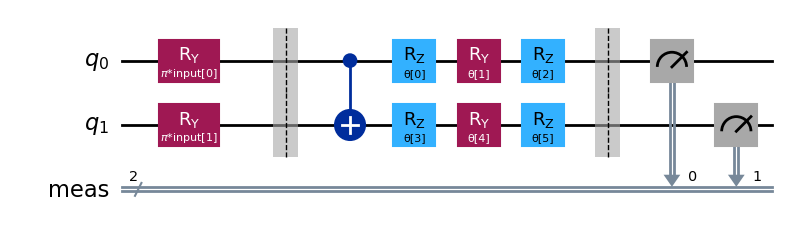

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator

# ==========================================
# 1. THE DATASET (Coupled Inputs)
# ==========================================
# We create a grid of (x1, x2) values
num_points = 6
x1_vals = np.linspace(-1, 1, num_points)
x2_vals = np.linspace(-1, 1, num_points)

# Create combinations of every x1 with every x2
X_train = []
Y_train = []

for x1 in x1_vals:
    for x2 in x2_vals:
        X_train.append([x1, x2])
        # The Target Function: sin(pi*x1) * cos(pi*x2)
        # This requires the circuit to multiply interactions
        Y_train.append(np.sin(np.pi*x1) * np.cos(np.pi*x2))

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# ==========================================
# 2. THE CIRCUIT (Paper Architecture)
# ==========================================
def create_surface_circuit():
    qc = QuantumCircuit(2)
    
    # --- A. Data Encoding ---
    # Encode x1 into Q0, x2 into Q1
    inputs = ParameterVector('input', 2)
    qc.ry(inputs[0] * np.pi, 0) # Scale input -1..1 to -pi..pi
    qc.ry(inputs[1] * np.pi, 1)
    qc.barrier()
    
    # --- B. Ansatz (Entanglement + RzRyRz) ---
    # We need 6 parameters (3 per qubit)
    weights = ParameterVector('θ', 6)
    
    # 1. Entanglement (Crucial for x1 * x2 interaction)
    qc.cx(0, 1)
    
    # 2. Trainable Rotations (Theorem 3.2)
    # Qubit 0
    qc.rz(weights[0], 0)
    qc.ry(weights[1], 0)
    qc.rz(weights[2], 0)
    # Qubit 1
    qc.rz(weights[3], 1)
    qc.ry(weights[4], 1)
    qc.rz(weights[5], 1)
            
    qc.measure_all()
    return qc, inputs, weights

qc, inputs, weights = create_surface_circuit()
print("Coupled Signal Circuit:")
qc.draw('mpl')




In [ ]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
sim = AerSimulator()

def get_prediction(x_in, w_in):
    # Bind parameters
    bind_dict = {inputs[i]: x_in[i] for i in range(2)}
    for i in range(6):
        bind_dict[weights[i]] = w_in[i]
        
    bound_qc = qc.assign_parameters(bind_dict)
    counts = sim.run(bound_qc, shots=1000).result().get_counts()
    
    # Expectation Value (-1 to 1)
    # We measure Parity of the whole system
    # Even Parity (00, 11) -> +1
    # Odd Parity (01, 10) -> -1
    p_even = 0
    p_odd = 0
    for k, v in counts.items():
        if k.count('1') % 2 == 0:
            p_even += v
        else:
            p_odd += v
            
    return (p_even - p_odd) / 1000

def compute_loss(w):
    loss = 0
    for i in range(len(X_train)):
        pred = get_prediction(X_train[i], w)
        target = Y_train[i]
        loss += (pred - target) ** 2
    return loss / len(X_train)

# ==========================================
# 4. TRAINING (Parameter Shift Rule)
# ==========================================
def get_gradients(w):
    grads = np.zeros_like(w)
    shift = np.pi/2
    for i in range(len(w)):
        w_plus = w.copy(); w_plus[i] += shift
        w_minus = w.copy(); w_minus[i] -= shift
        grads[i] = (compute_loss(w_plus) - compute_loss(w_minus)) / 2
    return grads

# Initialize
current_weights = np.random.rand(6) * 2 * np.pi
learning_rate = 0.5
loss_history = []

print("Training to learn surface z = sin(x)*cos(y)...")

for epoch in range(25):
    grads = get_gradients(current_weights)
    current_weights -= learning_rate * grads
    
    loss = compute_loss(current_weights)
    loss_history.append(loss)
    print(f"Epoch {epoch}: Loss = {loss:.4f}")




In [ ]:
# ==========================================
# 5. VISUALIZATION (3D Surface)
# ==========================================
# Generate predictions for the whole grid
Z_pred = []
for i in range(len(X_train)):
    Z_pred.append(get_prediction(X_train[i], current_weights))

Z_pred = np.array(Z_pred).reshape(num_points, num_points)
X_grid, Y_grid = np.meshgrid(x1_vals, x2_vals)
Z_real = np.sin(np.pi*X_grid) * np.cos(np.pi*Y_grid)

fig = plt.figure(figsize=(12, 5))

# Plot 1: The Real Function
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X_grid, Y_grid, Z_real, cmap=cm.coolwarm)
ax1.set_title("Real Target Function")

# Plot 2: The Quantum Prediction
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X_grid, Y_grid, Z_pred, cmap=cm.viridis)
ax2.set_title("Quantum Learned Surface")

plt.show()

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()

In [59]:
# prediction for a specific point
test_point = np.array([0.25, -0.25])  # (x1, x2)
pred = get_prediction(test_point, current_weights)
real = np.sin(np.pi*test_point[0]) * np.cos(np.pi*test_point[1])
print(f"Test Point: {test_point}, Prediction: {pred:.3f}, Real: {real:.3f}")

Test Point: [ 0.25 -0.25], Prediction: 0.506, Real: 0.500


Architecture (Rz-Ry-Rz + Entanglement):


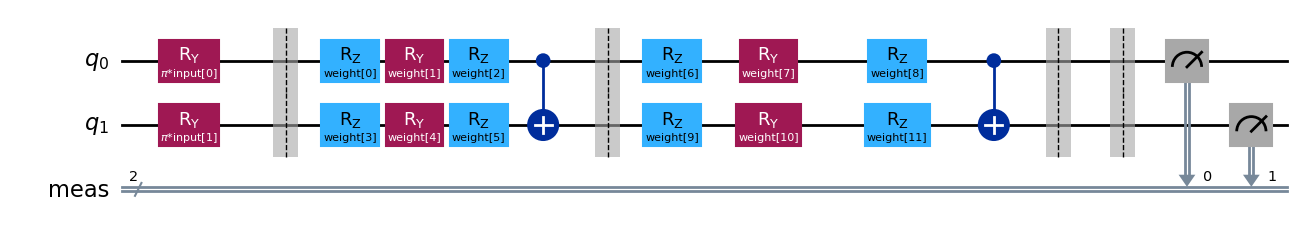

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator

# ==========================================
# 1. THE DATASET (XOR Problem)
# ==========================================
# Inputs: [x1, x2] -> Output: x1 XOR x2
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y_train = np.array([0, 1, 1, 0])

# ==========================================
# 2. THE QUANTUM CIRCUIT (Paper Architecture)
# ==========================================
def create_circuit(num_qubits, layers):
    qc = QuantumCircuit(num_qubits)
    
    # --- A. Input Parameters (Data Encoding) ---
    # We use Ry rotation to encode 0 or 1 input data
    inputs = ParameterVector('input', num_qubits)
    for i in range(num_qubits):
        qc.ry(inputs[i] * np.pi, i) # Map 0->0, 1->Pi (Flip)
    qc.barrier()
    
    # --- B. Trainable Ansatz (Theorem 3.2: Rz-Ry-Rz) ---
    # We need 3 parameters per qubit per layer
    num_params = 3 * num_qubits * layers
    weights = ParameterVector('weight', num_params)
    
    p_idx = 0
    for l in range(layers):
        # 1. Trainable Rotations (Rz Ry Rz) - Eq. 6 in Paper
        for q in range(num_qubits):
            qc.rz(weights[p_idx], q)
            p_idx += 1
            qc.ry(weights[p_idx], q)
            p_idx += 1
            qc.rz(weights[p_idx], q)
            p_idx += 1
        
        # 2. Entanglement (CNOTs) - Eq. 5 in Paper
        # Connect each qubit to its neighbor
        if num_qubits > 1:
            for q in range(num_qubits - 1):
                qc.cx(q, q+1)
        qc.barrier()
        
    # --- C. Measurement ---
    qc.measure_all()
    
    return qc, inputs, weights

# Define Model Config
NUM_QUBITS = 2  # Two inputs
LAYERS = 2      # Depth of the neural network
qc, param_input, param_weight = create_circuit(NUM_QUBITS, LAYERS)

print("Architecture (Rz-Ry-Rz + Entanglement):")
qc.draw('mpl')

